<a href="https://colab.research.google.com/github/waelrash1/forecastingmodelsPY/blob/main/CH09/CH09_exercises_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding external variables to our model

* Examining the SARIMAX model
* Exploring the use of external variables for forecasting
*  Forecasting using the SARIMAX model

## What we already covered?
* In chapters 4 through 8, we have increasingly built a general model that allows us to consider more complex patterns in time series. 

* We started our journey with the autoregressive and moving average processes before combining them into the ARMA model. 
* Then we added a layer of complexity to model non-stationary time series, leading us to the ARIMA model. 
* Finally, in chapter 8 we added yet another layer to ARIMA that allows us to consider seasonal patterns in our forecasts, which resulted in the SARIMA model.

> So far, each model that we have explored and used to produce forecasts has
considered only the time series itself. In other words, past values of the time series were used as predictors of future values. However, it is possible that external variables also have an impact on our time series and can therefore be good predictors of future values


## Exogenous vs endogenous variable

* In statistics the term **exogenous** is used to describe Adding external variables to our model predictors or input variables, 
* while **endogenous** is used to define the target variable— what we are trying to predict.
* With the SARIMAX model, we can now consider external variables, or exogenous variables, when forecasting a time series

## Example:
* As a guiding example, we’ll use a macroeconomics dataset from the United States, collected quarterly from 1959 to 2009, to forecast the real gross domestic product(GDP).

* Without diving into the technicalities of measuring the GDP, we’ll define the GDP as the sum of consumption C, government spending G, investments I, and net exports NX, as shown following equation:

$$
\Large GDP = C + G + I + NX
$$

* Each element of equation is likely affected by some external variable. For example,consumption is likely impacted by the unemployment rate, because if fewer people are employed, consumption is likely to decrease. 
* Interest rates can also have an impact, because if they go up, it is harder to borrow money, and spending decreases as a result. We can also think of currency exchange rates as having an impact on net
exports.
* A weaker local currency will generally stimulate exports and make imports
more expensive. Thus, we can see how many exogenous variables can likely impact
the real GDP of the United States.

## SARIMAX model
* The **SARIMAX model** simply adds a linear combination of exogenous variables to the SARIMA model. This allows us to model the impact of external variables on the future value of a time series.

> We can loosely define the SARIMAX model as follows:


$$
\Large y_t= SARIMA(p,d,q)(P,D,Q)_m+\sum_{i}^{n}\beta_i X_{t}^{i}
$$

* The **SARIMAX model** is the most general model for forecasting time series. You can see that if you have no seasonal patterns, it becomes an ARIMAX model. With no exogenous variables, it is a SARIMA model. With no seasonality or exogenous variables, it becomes an ARIMA mode

## Exploring the exogenous variables of the US macroeconomics dataset

* Let’s load the US macroeconomics dataset and explore the different exogenous variables available to us to forecast the real GDP.

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


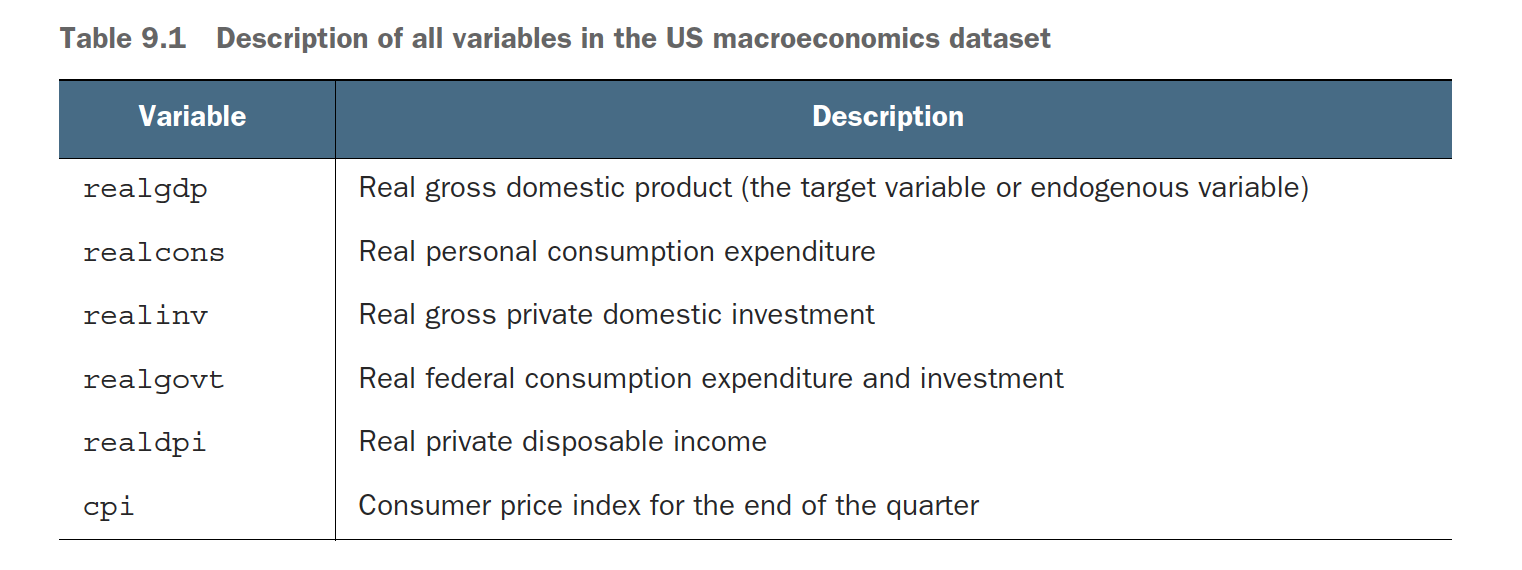

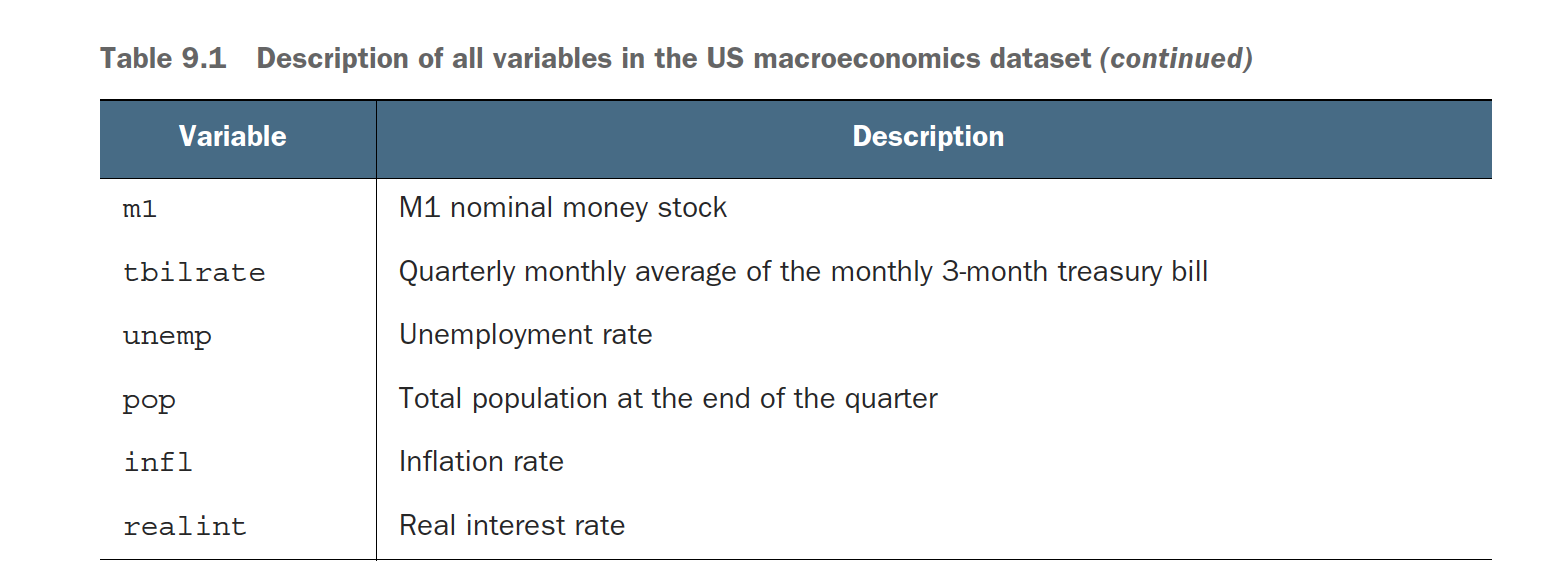

For the sake of simplicity and clarity, we will only work with six variables in this chapter: the **real GDP**, which is our target, and the next five variables listed in this table:


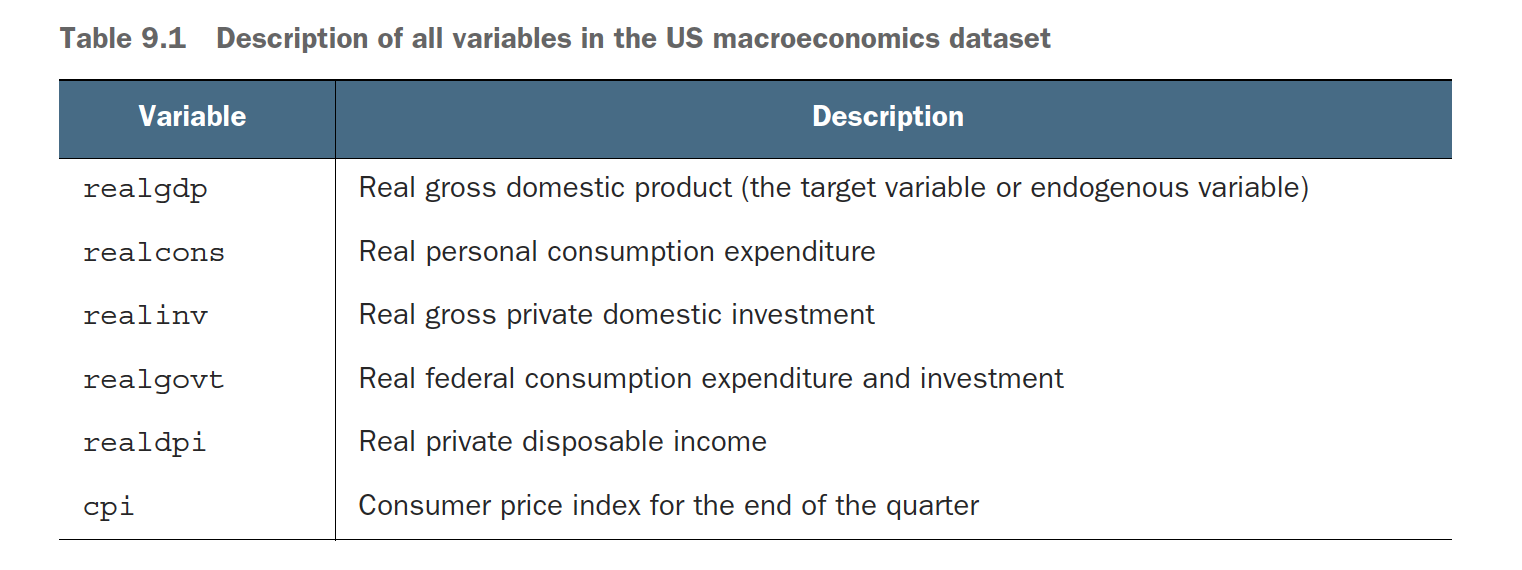



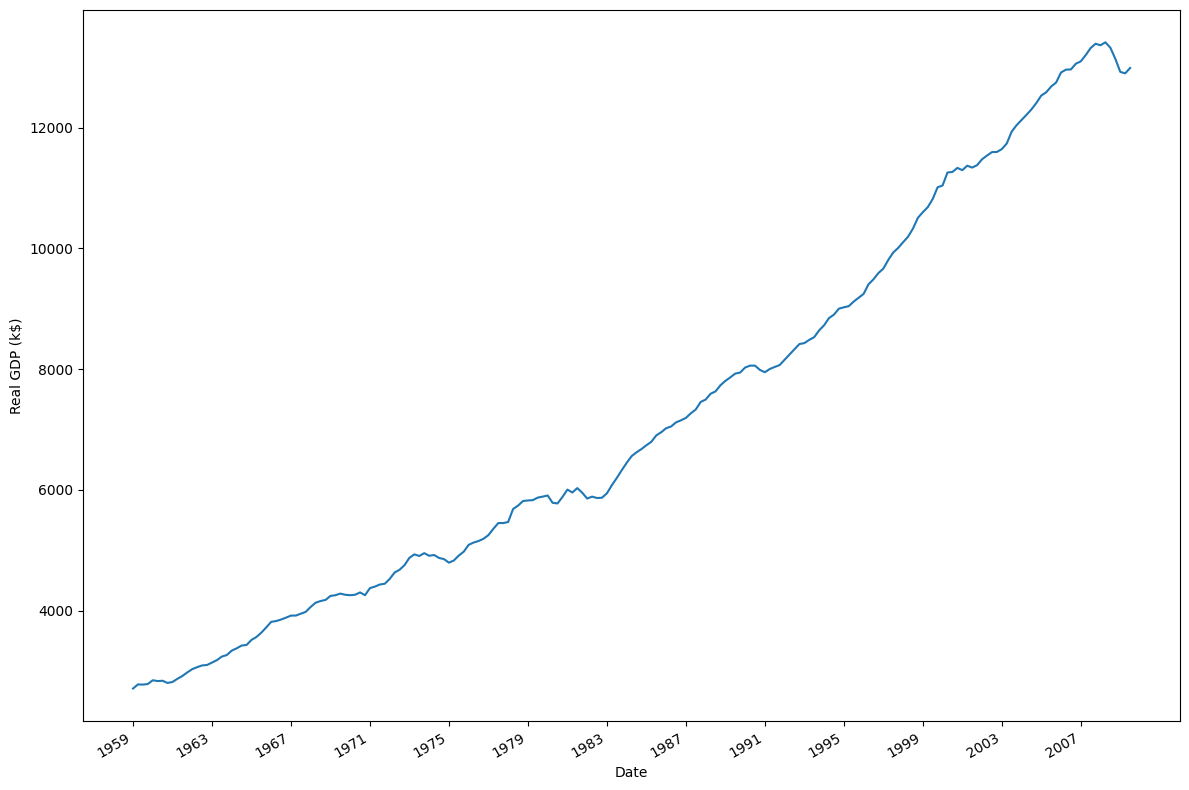

In [5]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 
                        'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

In [7]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647144
p-value: 0.9982455372335032


The series is not stationary. Let's apply differencing.

In [8]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


The series is not stationary. Therefore, $d=1$ and $D=0$. Also, since we have quarterly data, then $m=4$.

In [9]:
def optimize_SARIMAX(train, exog, order_list, d, D, s) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                train,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
target_train = target[:200]
exog_train = exog[:200]

In [11]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [13]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [14]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 0)",1757.107242
1,"(3, 3, 0, 0)",1757.890596
2,"(2, 2, 0, 2)",1758.333051
3,"(2, 2, 0, 0)",1759.093324
4,"(2, 2, 2, 0)",1759.587608
...,...,...
251,"(3, 2, 2, 1)",1776.806705
252,"(3, 2, 1, 3)",1776.867132
253,"(3, 2, 1, 1)",1776.944899
254,"(3, 2, 1, 2)",1778.131896


The model with the lowest AIC is a $SARIMAX(2,1,2)(1,0,0)_4$ mode;.

In [15]:
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.554
Date:                            Sun, 16 Apr 2023   AIC                           1757.107
Time:                                    23:21:09   BIC                           1813.093
Sample:                                         0   HQIC                          1779.766
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9570      0.053     17.973      0.000       0.853       1.061
realinv        1.0018      0.042   

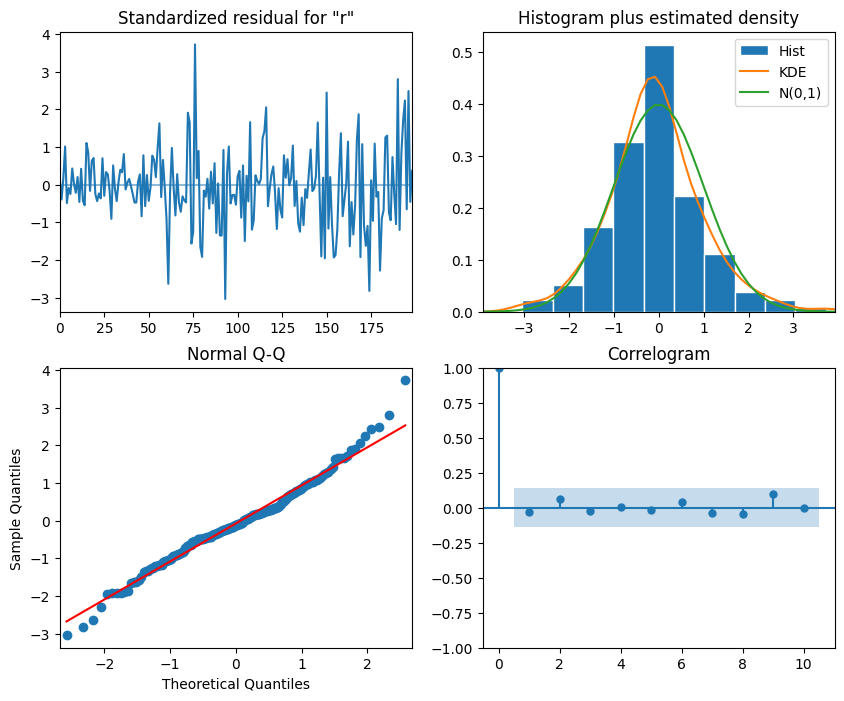

In [16]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [19]:
residuals = best_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))



,lb_stat,lb_pvalue
1,0.014174,0.905233
2,0.061131,0.969897
3,0.076644,0.994485
4,0.213687,0.994683
5,0.223341,0.998842
6,0.226650,0.999777
7,0.226909,0.999961
8,0.293642,0.999983
9,0.308340,0.999996
10,0.309189,0.999999


In [20]:
def recursive_forecast(train, exog, train_len, horizon, window, method) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = train[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(train[:i], exog[:i], order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [21]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13345.323465
197,13415.266,13366.865,13374.991346
198,13324.600,13415.266,13368.458066
199,13141.920,13324.600,13332.370212
200,12925.410,13141.920,13135.312953
201,12901.504,12925.410,12887.761999
202,12990.341,12901.504,12868.822028


In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.70080434122877


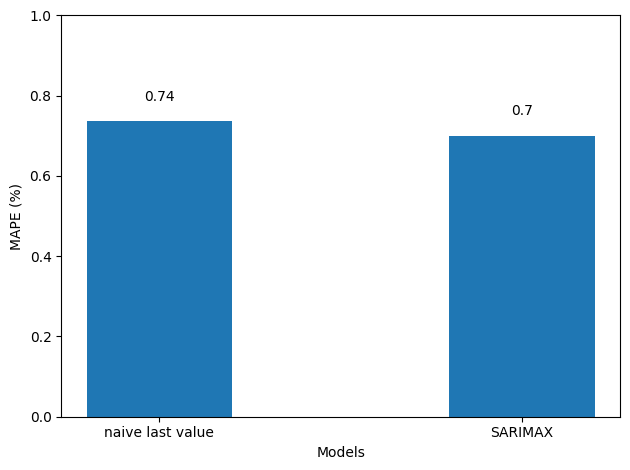

In [24]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

In chapter 9, using fewer exogenous variables, we achived a MAPE of 0.7039%. Using all exgogenous variables, we achieved a MAPE of 0.7019%. It is only very slightly better.